# Fully Convolutional Interior/Edge Segmentation for 2D Data

---

Classifies each pixel as either Cell Edge, Cell Interior, or Background.

There are 2 different Cell Edge classes (Cell-Cell Boundary and Cell-Background Boundary)

In [1]:
import os
import errno

import numpy as np

import deepcell

Using TensorFlow backend.


### Load the training data

In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = 'HeLa_S3.npz'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(filename)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

X.shape: (6208, 216, 256, 1)
y.shape: (6208, 216, 256, 1)


### Set up filepath constants

In [3]:
# the path to the data file is currently required for `train_model_()` functions

# NOTE: Change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [4]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

### Set up training parameters

In [5]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

n_epoch = 5  # Number of training epochs
test_size = .10  # % of data saved as test
norm_method = 'std'  # data normalization
receptive_field = 61  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 3  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

# Transformation settings
transform = 'deepcell'
dilation_radius = 1  # change dilation radius for edge dilation
n_features = 4  # (cell-background edge, cell-cell edge, cell interior, background)

### First, create a foreground/background separation model

#### Instantiate the fgbg model

In [6]:
from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=tuple(X_train.shape[1:]),
    last_only=False)

#### Train the model fgbg model

In [7]:
from deepcell.training import train_model_conv

fgbg_model = train_model_conv(
    model=fgbg_model,
    dataset=DATA_FILE,  # full path to npz file
    expt='conv_fgbg',
    test_size=test_size,
    optimizer=optimizer,
    n_epoch=n_epoch,
    batch_size=batch_size,
    transform='fgbg',
    model_dir=MODEL_DIR,
    log_dir=LOG_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

X_train shape: (6984, 216, 256, 1)
y_train shape: (6984, 216, 256, 1)
X_test shape: (776, 216, 256, 1)
y_test shape: (776, 216, 256, 1)
Output Shape: (None, 216, 256, 2)
Number of Classes: 2
Training on 1 GPUs
Epoch 1/5
6983/6984 [============================>.] - ETA: 0s - loss: 0.1790 - model_loss: 0.0401 - model_1_loss: 0.0379 - model_2_loss: 0.0365 - model_3_loss: 0.0363 - model_acc: 0.9478 - model_1_acc: 0.9480 - model_2_acc: 0.9479 - model_3_acc: 0.9473
Epoch 00001: val_loss improved from inf to 0.34497, saving model to /data/models/2018-12-14_HeLa_S3_conv_fgbg.h5
6984/6984 [==============================] - 961s 138ms/step - loss: 0.1790 - model_loss: 0.0401 - model_1_loss: 0.0379 - model_2_loss: 0.0365 - model_3_loss: 0.0363 - model_acc: 0.9478 - model_1_acc: 0.9480 - model_2_acc: 0.9479 - model_3_acc: 0.9473 - val_loss: 0.3450 - val_model_loss: 0.0815 - val_model_1_loss: 0.0759 - val_model_2_loss: 0.0802 - val_model_3_loss: 0.0793 - val_model_acc: 0.9828 - val_model_1_acc: 0.9

### Next, Create a model for the watershed energy transform

#### Instantiate the deepcell transform model

In [8]:
from deepcell import model_zoo

conv_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=n_features,
    norm_method=norm_method,
    n_conv_filters=32,
    n_dense_filters=128,
    last_only=False,
    input_shape=tuple(X_train.shape[1:]))

#### Train the deepcell transform model

In [9]:
from deepcell.training import train_model_conv

conv_model = train_model_conv(
    model=conv_model,
    dataset=DATA_FILE,  # full path to npz file
    expt='conv',
    test_size=test_size,
    transform=transform,
    dilation_radius=dilation_radius,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    log_dir=LOG_DIR,
    model_dir=MODEL_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

X_train shape: (6984, 216, 256, 1)
y_train shape: (6984, 216, 256, 1)
X_test shape: (776, 216, 256, 1)
y_test shape: (776, 216, 256, 1)
Output Shape: (None, 216, 256, 4)
Number of Classes: 4
Training on 1 GPUs
Epoch 1/5
6983/6984 [============================>.] - ETA: 0s - loss: 1.0642 - model_5_loss: 0.2517 - model_6_loss: 0.2552 - model_7_loss: 0.2511 - model_8_loss: 0.2490 - model_5_acc: 0.8027 - model_6_acc: 0.8035 - model_7_acc: 0.8012 - model_8_acc: 0.8013
Epoch 00001: val_loss improved from inf to 1.26935, saving model to /data/models/2018-12-14_HeLa_S3_conv.h5
6984/6984 [==============================] - 1441s 206ms/step - loss: 1.0644 - model_5_loss: 0.2518 - model_6_loss: 0.2552 - model_7_loss: 0.2512 - model_8_loss: 0.2491 - model_5_acc: 0.8027 - model_6_acc: 0.8035 - model_7_acc: 0.8012 - model_8_acc: 0.8013 - val_loss: 1.2694 - val_model_5_loss: 0.3107 - val_model_6_loss: 0.3049 - val_model_7_loss: 0.2968 - val_model_8_loss: 0.2992 - val_model_5_acc: 0.9456 - val_model_6_

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6983/6984 [============================>.] - ETA: 0s - loss: 0.9229 - model_5_loss: 0.2170 - model_6_loss: 0.2181 - model_7_loss: 0.2154 - model_8_loss: 0.2140 - model_5_acc: 0.8066 - model_6_acc: 0.8072 - model_7_acc: 0.8062 - model_8_acc: 0.8065
Epoch 00003: val_loss improved from 1.26268 to 1.22912, saving model to /data/models/2018-12-14_HeLa_S3_conv.h5
6984/6984 [==============================] - 1406s 201ms/step - loss: 0.9228 - model_5_loss: 0.2170 - model_6_loss: 0.2180 - model_7_loss: 0.2153 - model_8_loss: 0.2140 - model_5_acc: 0.8066 - model_6_acc: 0.8072 - model_7_acc: 0.8062 - model_8_acc: 0.8065 - val_loss: 1.2291 - val_model_5_loss: 0.2990 - val_model_6_loss: 0.2977 - val_model_7_loss: 0.2867 - val_model_8_loss: 0.2871 - val_model_5_acc: 0.9519 - val_model_6_acc: 0.9523 - val_model_7_acc: 0.9498 - val_model_8_acc: 0.9521
Epoch 4/5
1320/6984 [====>.........................] - ETA: 18:20 - loss: 0.9119 - model_5_loss: 0.2152 - model_6_loss: 0.2153 - model_7_loss: 0.2120 - 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6983/6984 [============================>.] - ETA: 0s - loss: 0.9068 - model_5_loss: 0.2130 - model_6_loss: 0.2136 - model_7_loss: 0.2115 - model_8_loss: 0.2098 - model_5_acc: 0.8052 - model_6_acc: 0.8049 - model_7_acc: 0.8052 - model_8_acc: 0.8051
Epoch 00004: val_loss improved from 1.22912 to 1.21301, saving model to /data/models/2018-12-14_HeLa_S3_conv.h5
6984/6984 [==============================] - 1410s 202ms/step - loss: 0.9067 - model_5_loss: 0.2130 - model_6_loss: 0.2136 - model_7_loss: 0.2115 - model_8_loss: 0.2098 - model_5_acc: 0.8052 - model_6_acc: 0.8048 - model_7_acc: 0.8051 - model_8_acc: 0.8051 - val_loss: 1.2130 - val_model_5_loss: 0.2978 - val_model_6_loss: 0.2877 - val_model_7_loss: 0.2856 - val_model_8_loss: 0.2831 - val_model_5_acc: 0.9496 - val_model_6_acc: 0.9504 - val_model_7_acc: 0.9493 - val_model_8_acc: 0.9520
Epoch 5/5
 245/6984 [>.............................] - ETA: 21:48 - loss: 0.9601 - model_5_loss: 0.2289 - model_6_loss: 0.2308 - model_7_loss: 0.2230 - 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6983/6984 [============================>.] - ETA: 0s - loss: 0.9098 - model_5_loss: 0.2150 - model_6_loss: 0.2141 - model_7_loss: 0.2116 - model_8_loss: 0.2103 - model_5_acc: 0.8076 - model_6_acc: 0.8071 - model_7_acc: 0.8076 - model_8_acc: 0.8074
Epoch 00005: val_loss did not improve from 1.21301
6984/6984 [==============================] - 1406s 201ms/step - loss: 0.9098 - model_5_loss: 0.2150 - model_6_loss: 0.2141 - model_7_loss: 0.2116 - model_8_loss: 0.2102 - model_5_acc: 0.8076 - model_6_acc: 0.8071 - model_7_acc: 0.8076 - model_8_acc: 0.8074 - val_loss: 1.2219 - val_model_5_loss: 0.2988 - val_model_6_loss: 0.2899 - val_model_7_loss: 0.2907 - val_model_8_loss: 0.2835 - val_model_5_acc: 0.9517 - val_model_6_acc: 0.9483 - val_model_7_acc: 0.9511 - val_model_8_acc: 0.9503


### Run the model

In [10]:
# make predictions on testing data
test_images = conv_model.predict(X_test)[-1]
test_images_fgbg = fgbg_model.predict(X_test)[-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

watershed transform shape: (1552, 216, 256, 4)
segmentation mask shape: (1552, 216, 256, 2)


In [11]:
# Collapse predictions into semantic segmentation mask
argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=-1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('argmax shape:', argmax_images.shape)

argmax shape: (1552, 216, 256, 1)


In [15]:
# threshold the foreground/background
# and remove background from watershed transform
threshold = 0.5
fg_thresh = test_images_fgbg[..., 1] > threshold

fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
argmax_images_post_fgbg = argmax_images * fg_thresh

In [22]:
# Apply watershed method with the interior segmentation as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.feature import peak_local_max

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    image = fg_thresh[i, ..., 0]
    distance = argmax_images_post_fgbg[i, ..., 0]

    local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
                                exclude_border=False, indices=False, labels=image)

    markers = label(local_maxi)
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=-1)

Image number: 1198


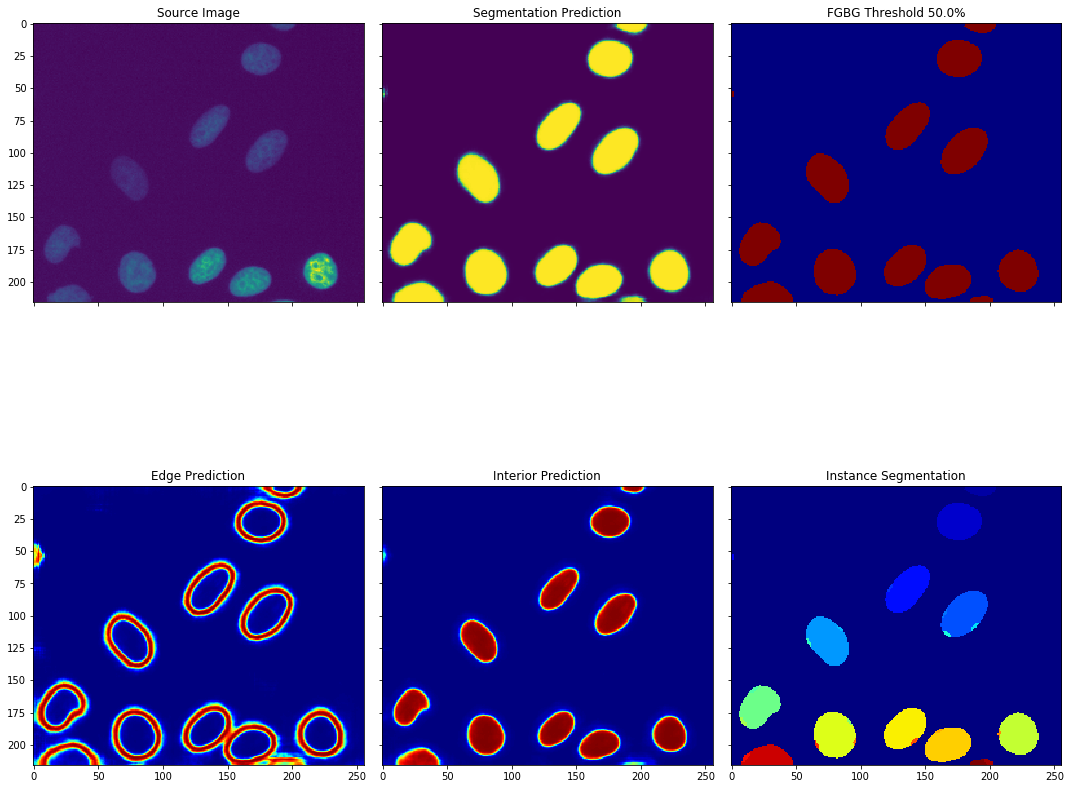

In [23]:
import matplotlib.pyplot as plt

index = 1198#np.random.randint(low=0, high=X_test.shape[0])
print('Image number:', index)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

ax[3].imshow(test_images[index, ..., 0] + test_images[index, ..., 1], cmap='jet')
ax[3].set_title('Edge Prediction')

ax[4].imshow(test_images[index, ..., 2], cmap='jet')
ax[4].set_title('Interior Prediction')

ax[5].imshow(watershed_images[index, ..., 0], cmap='jet')
ax[5].set_title('Instance Segmentation')

fig.tight_layout()
plt.show()